**Project Overview**

The goal of this project is to collect motion data, extract meaningful features, and use a Hidden Markov Model (HMM) to infer human activity states such as standing, walking, jumping, and still.

Sensors Recorded:
- **Accelerometer:** x, y, z axes
- **Gyroscope:** x, y, z axes

Activities Performed:
| Activity | Duration | Notes |
|-----------|-----------|--------|
| Standing | 5–10 s | Keep the phone steady at waist level |
| Walking | 5–10 s | Maintain a consistent pace |
| Jumping | 5–10 s | Perform 3–5 continuous jumps |
| Still | 5–10 s | Place the phone on a flat surface |

Each recording was taken at a sampling rate of **70 Hz**, and the collected data was saved as `.csv` files with timestamps.


**Feature Extraction Summary**

From the raw accelerometer and gyroscope readings, features were extracted in both **time** and **frequency** domains to capture movement patterns.

Examples of extracted features:
- **Time-domain features:** mean, variance, standard deviation, signal magnitude area (SMA), correlations between axes.
- **Frequency-domain features:** dominant frequency, spectral energy, FFT components.

The extracted features were saved in a file called `features.csv`, which contains all four activities combined with their corresponding labels.


Load Extracted Data

In [15]:
from hmmlearn import hmm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix


In [16]:
import pandas as pd

# Load preprocessed features
df = pd.read_csv("features.csv")

# Standardize column name to 'label'
df.rename(columns={'activity': 'label'}, inplace=True)


#session_splitting
threshold = 2.0
df["session_id"] = (df["start_time"].diff() > threshold).cumsum()

# Display basic information
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (948, 95)


,accel_x_mean,accel_x_std,accel_x_var,accel_x_mad,accel_y_mean,accel_y_std,accel_y_var,accel_y_mad,accel_z_mean,accel_z_std,...,acc_res_spec_energy,acc_res_fft_top1_mag,acc_res_fft_top1_freq,acc_res_fft_top2_mag,acc_res_fft_top2_freq,acc_res_fft_top3_mag,acc_res_fft_top3_freq,label,start_time,session_id
0,-0.325147,1.005483,1.010997,0.715388,-0.125287,1.950710,3.805271,1.288558,-0.052421,7.376959,...,50.754583,248.492811,0.781250,224.096697,0.390625,147.161871,3.906250,jumping,1.761134e+09,0
1,-0.333427,1.212630,1.470472,0.896227,-0.036922,2.340061,5.475887,1.697479,0.170994,8.711320,...,65.812950,183.212361,3.906250,164.318067,1.953125,137.923398,0.781250,jumping,1.761134e+09,0
2,-0.150583,1.298404,1.685853,0.915027,-0.092910,1.918203,3.679501,1.403808,-0.045061,8.365517,...,64.546681,193.348538,3.906250,176.854559,1.953125,164.362721,5.859375,jumping,1.761134e+09,0
3,-0.137955,1.175404,1.381574,0.768837,-0.245090,1.596382,2.548437,1.141766,0.054054,7.954364,...,58.464855,275.642796,0.781250,175.347922,3.906250,158.849126,0.390625,jumping,1.761134e+09,0
4,-0.134741,0.959452,0.920549,0.607052,-0.155564,1.428992,2.042019,0.890355,0.201396,6.758013,...,41.634446,379.684283,0.390625,128.718180,3.906250,118.783268,3.515625,jumping,1.761134e+09,0


Data Inspection

In [17]:
# Check for missing values and class distribution
print("Missing values:\n", df.isna().sum())
print("\nClass distribution:\n", df['label'].value_counts())

Missing values:
 accel_x_mean             0
accel_x_std              0
accel_x_var              0
accel_x_mad              0
accel_y_mean             0
                        ..
acc_res_fft_top3_mag     0
acc_res_fft_top3_freq    0
label                    0
start_time               0
session_id               0
Length: 95, dtype: int64

Class distribution:
 label
walking     266
still       247
jumping     227
standing    208
Name: count, dtype: int64


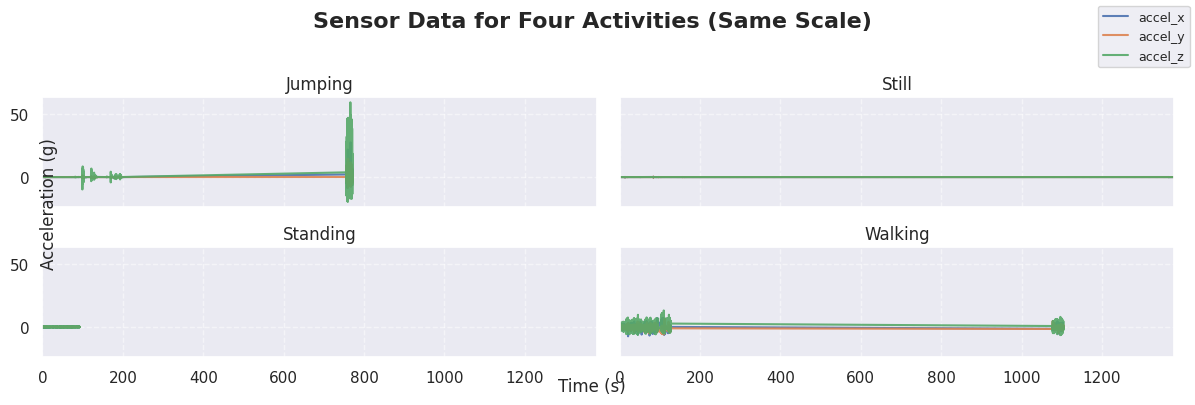

In [55]:


jumping = pd.read_csv('data/combined/omar_jumping_combined.csv')
still = pd.read_csv('data/combined/nicolle_still_combined.csv')
standing = pd.read_csv('data/combined/nicolle_standing_combined.csv')
walking = pd.read_csv('data/combined/omar_walking_combined.csv')

def normalize_time(df):
    df['time'] = (df['timestamp'] - df['timestamp'].iloc[0]) / 1e9  # nanoseconds to seconds
    return df

jumping = normalize_time(jumping)
still = normalize_time(still)
standing = normalize_time(standing)
walking = normalize_time(walking)

all_dfs = [jumping, still, standing, walking]

# Compute global y-limits across all accelerometer axes so all subplots use the same vertical scale
y_mins = [df[['accel_x', 'accel_y', 'accel_z']].min().min() for df in all_dfs]
y_maxs = [df[['accel_x', 'accel_y', 'accel_z']].max().max() for df in all_dfs]
global_ymin = min(y_mins)
global_ymax = max(y_maxs)
# add a small margin (5%) for visual breathing room
yrange = global_ymax - global_ymin if global_ymax != global_ymin else abs(global_ymax) * 0.1 + 1e-6
global_ymin -= 0.05 * yrange
global_ymax += 0.05 * yrange

# Compute a common x-limit (time) so horizontal scale is also comparable
global_xmax = max(df['time'].max() for df in all_dfs)
global_xmin = 0.0  # since you normalized time to start at 0

# Create subplots (2x2 grid). Use sharex/sharey to keep tick alignment if desired.
fig, axes = plt.subplots(2, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle("Sensor Data for Four Activities (Same Scale)", fontsize=16, fontweight='bold')

# Define a helper function to plot each activity
def plot_activity(ax, df, title):
    ax.plot(df['time'], df['accel_x'], label='accel_x', alpha=0.9)
    ax.plot(df['time'], df['accel_y'], label='accel_y', alpha=0.9)
    ax.plot(df['time'], df['accel_z'], label='accel_z', alpha=0.9)
    ax.set_title(title)
    ax.set_xlim(global_xmin, global_xmax)
    ax.set_ylim(global_ymin, global_ymax)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.label_outer()  # hide inner labels for a cleaner layout

# Plot each on its subplot
plot_activity(axes[0, 0], jumping, "Jumping")
plot_activity(axes[0, 1], still, "Still")
plot_activity(axes[1, 0], standing, "Standing")
plot_activity(axes[1, 1], walking, "Walking")

# Put a single legend for the whole figure (avoids overlapping small subplot legends)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=9)

# Global x/y labels (centered)
fig.text(0.5, 0.03, "Time (s)", ha='center', fontsize=12)
fig.text(0.04, 0.5, "Acceleration (g)", va='center', rotation='vertical', fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig("combined_activity_visualization_same_scale.png", dpi=300)

plt.show()

#### Preparing data for HMM

##### Split Data by Session

- **Objective:** Prevent data leakage by ensuring entire sessions are assigned to either training or testing.  
- **Procedure:**  
  1. Identify all unique `session_id`s in the dataset.  
  2. Randomly split these session IDs into training (80%) and testing (20%) sets.  
  3. Assign all rows belonging to a training session to the training set, and all rows of testing sessions to the testing set.  
  4. Verify that all activity labels are represented in both sets to ensure coverage.  
- **Outcome:** Sequences from the same session do not appear in both training and testing, preserving sequence integrity for model training.


In [ ]:
session_ids = df["session_id"].unique()
train_sess, test_sess = train_test_split(session_ids, test_size=0.2, random_state=42)
train_df = df[df["session_id"].isin(train_sess)].reset_index(drop=True)
test_df  = df[df["session_id"].isin(test_sess)].reset_index(drop=True)


# ensure all activities present in train 
print("train activity counts:\n", train_df["label"].value_counts())
print("test activity counts:\n", test_df["label"].value_counts())

train activity counts:
 label
walking     223
standing    195
still       186
jumping     166
Name: count, dtype: int64
test activity counts:
 label
jumping     61
still       61
walking     43
standing    13
Name: count, dtype: int64


#### Build Feature and Label Sequences per Session

- **Objective:** Convert the dataset into sequences for each session, preserving temporal order for sequence models like HMMs.  
- **Procedure:**  
  1. For each unique `session_id` in the dataset:  
     - Extract all rows corresponding to that session.  
     - Collect feature columns into a 2D array representing the observation sequence.  
     - Collect the corresponding activity labels into a 1D array representing the label sequence.  
  2. Append the feature and label sequences to separate lists for training or testing.  
- **Outcome:** Two aligned lists of sequences:  
  - `X_train_seqs` / `X_test_seqs` → observation sequences per session.  
  - `y_train_seqs` / `y_test_seqs` → label sequences per session.  
- **Notes:** Each sequence preserves the temporal order of activities within the session.


In [19]:
# --- Build sequences per session ---
def build_seqs_from_df(df_in, feature_cols, session_col="session_id"):
    seqs_X = []
    seqs_y = []
    for sid in df_in[session_col].drop_duplicates().tolist():
        sub = df_in[df_in[session_col] == sid]
        X = sub[feature_cols].to_numpy(dtype=float)
        y = sub["label"].to_numpy()
        if len(y) > 0:
            seqs_X.append(X)
            seqs_y.append(y)
    return seqs_X, seqs_y

feature_cols = [c for c in df.columns if c not in ["label", "session_id"]]
X_train_seqs, y_train_seqs = build_seqs_from_df(train_df, feature_cols, session_col="session_id")
X_test_seqs,  y_test_seqs  = build_seqs_from_df(test_df,  feature_cols, session_col="session_id")




#### Encode Labels

- **Objective:** Convert activity labels to numeric indices for modeling.  
- **Procedure:**  
  1. Identify all unique activity labels and sort them.  
  2. Map each label to a unique integer (`label2idx`) and vice versa (`idx2label`).  
  3. Replace labels in each sequence with corresponding indices.  
- **Outcome:** Encoded label sequences (`y_train_enc`, `y_test_enc`) ready for HMM or other models.


In [ ]:
# --- Encode labels ---

unique_labels = sorted(df['label'].unique())
label2idx = {lab:i for i,lab in enumerate(unique_labels)}
idx2label = {i:lab for lab,i in label2idx.items()}

y_train_enc = [np.array([label2idx[v] for v in seq]) for seq in y_train_seqs]
y_test_enc  = [np.array([label2idx[v] for v in seq]) for seq in y_test_seqs]

## Scale Features

- **Objective:** Normalize feature values for consistent model training.  
- **Procedure:**  
  1. Stack all training sequences vertically to fit the scaler.  
  2. Apply `StandardScaler` to transform each sequence to zero mean and unit variance.  
  3. Scale both training and test sequences using the same scaler.  
- **Outcome:** Scaled feature sequences (`X_train_scaled`, `X_test_scaled`) suitable for HMM training.


In [ ]:

# --- Scale Features ---

scaler = StandardScaler()
scaler.fit(np.vstack(X_train_seqs))
X_train_scaled = [scaler.transform(seq) for seq in X_train_seqs]
X_test_scaled  = [scaler.transform(seq) for seq in X_test_seqs]

In [22]:
# ---  Prepare HMM Input ---
# HMM expects a single 2D array with all sequences concatenated,
# and a 'lengths' list indicating the length of each sequence.

X_train_concat = np.vstack(X_train_scaled)
lengths = [len(seq) for seq in X_train_scaled]
n_states = len(unique_labels)  # Number of hidden states = number of unique label

**Defining Model Components**

In a Hidden Markov Model (HMM), we define the following key elements:

| Element | Description |
|----------|--------------|
| **Hidden States (Z)** | The underlying activities (e.g., standing, walking, jumping, still). |
| **Observations (X)** | Feature vectors derived from accelerometer and gyroscope signals. |
| **Transition Probabilities (A)** | Probability of transitioning from one activity to another. |
| **Emission Probabilities (B)** | Probability of observing a specific feature pattern given an activity. |
| **Initial State Probabilities (π)** | Likelihood of starting in a specific activity. |

We will now define these components based on our dataset.

In [23]:


model = hmm.GaussianHMM(n_components=len(unique_labels), covariance_type='diag',
                        n_iter=200, tol=1e-4, verbose=True, random_state=42)

model.fit(X_train_concat, lengths)

mon = getattr(model, "monitor_", None)
converged = None
history_last = None
if mon is not None:
    # try common attribute names for convergence flag
    if hasattr(mon, "converged"):
        converged = mon.converged
    elif hasattr(mon, "converged_"):
        converged = mon.converged_
    # safe handling of history (scalar, array, list)
    hist = getattr(mon, "history", None)
    if hist is not None:
        arr = np.atleast_1d(np.asarray(hist))
        history_last = arr[-10:].tolist()  # last up to 10 entries

print("Converged:", converged)
print("Log-likelihood history (last entries):", history_last)

# Extract model components
A = model.transmat_
B_means = model.means_
B_covars = model.covars_
pi = model.startprob_

print("\nTransition matrix A:\n", A)
print("\nMeans shape:", B_means.shape)
print("Covars shape:", B_covars.shape)
print("\nStart probabilities pi:\n", pi)

Converged: True
Log-likelihood history (last entries): [25390.446753153003, 25437.94295519574, 25443.49674282571, 25449.47105187665, 25456.029847431495, 25459.616033337617, 25459.617319317702, 25459.617617111704, 25459.61773018859, 25459.617777385425]

Transition matrix A:
 [[0.97122302 0.         0.02158273 0.00719424]
 [0.00574618 0.94811976 0.04613406 0.        ]
 [0.01653088 0.02491472 0.95442168 0.00413272]
 [0.         0.00662252 0.00662252 0.98675497]]

Means shape: (4, 93)
Covars shape: (4, 93, 93)

Start probabilities pi:
 [0.1875  0.25    0.34375 0.21875]


         1  -82359.64870945             +nan
         2   12273.92744221  +94633.57615167
         3   21029.91366267   +8755.98622045
         4   23039.73373843   +2009.82007576
         5   23937.96682832    +898.23308989
         6   24443.92365004    +505.95682172
         7   24861.55131903    +417.62766899
         8   25080.89459410    +219.34327507
         9   25106.23830143     +25.34370733
        10   25390.44675315    +284.20845172
        11   25437.94295520     +47.49620204
        12   25443.49674283      +5.55378763
        13   25449.47105188      +5.97430905
        14   25456.02984743      +6.55879555
        15   25459.61603334      +3.58618591
        16   25459.61731932      +0.00128598
        17   25459.61761711      +0.00029779
        18   25459.61773019      +0.00011308
        19   25459.61777739      +0.00004720


Visualizing Transitions

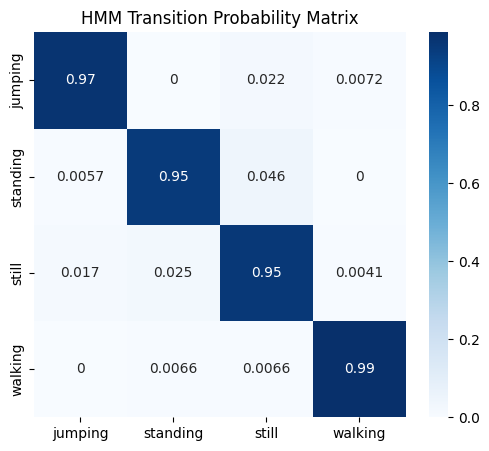

In [24]:

plt.figure(figsize=(6,5))
sns.heatmap(A, annot=True, cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("HMM Transition Probability Matrix")
plt.show()

This matrix was created by computing simple transition frequencies between our activity labels in features.csv.

That means:
- We have real transitions estimated from your labeled sequences.
- But the HMM parameters (like emission probabilities and the actual fitted A matrix) are not yet optimized — they’ll be updated after model training.

## Supervised HMM Implementation (From Scratch)

- **Objective:** Build a Hidden Markov Model using labeled sequences without relying on external HMM libraries.  

- **Steps:**

1. **Fit Supervised HMM (`fit_supervised_hmm`)**
   - **Initial probabilities (`π`)**: Count the first label in each training sequence and normalize.  
   - **Transition matrix (`A`)**: Count state-to-state transitions across sequences; normalize rows; handle zero-row cases.  
   - **Emission parameters (`means` and `covs`)**:  
     - Group feature vectors by their corresponding state.  
     - Compute per-state mean and covariance matrix.  
     - Add small regularization to covariance to ensure numerical stability.

2. **Log Emission Probabilities (`log_emission`)**
   - Compute the log-probability of each observation given each state's Gaussian distribution.

3. **Viterbi Decoding (`viterbi`)**
   - Dynamic programming algorithm to find the most likely sequence of hidden states for a given observation sequence.  
   - Uses log probabilities for numerical stability.  
   - Outputs predicted state sequence.

4. **Train and Decode**
   - Fit supervised HMM on scaled training sequences.  
   - Decode both training and test sequences to inspect model predictions.  

- **Outcome:**  
  - `pi`: learned initial state probabilities.  
  - `A`: learned transition probabilities.  
  - `means` and `covs`: emission Gaussian parameters.  
  - `y_test_pred_enc`: predicted states for each test sequence.


In [25]:

def fit_supervised_hmm(X_seqs, y_seqs, n_states, reg=1e-6):
    pi_counts = np.zeros(n_states)
    for y in y_seqs:
        pi_counts[y[0]] += 1
    pi = (pi_counts + 1e-8) / (pi_counts.sum() + 1e-8)
    A_counts = np.zeros((n_states, n_states))
    for y in y_seqs:
        for t in range(len(y)-1):
            A_counts[y[t], y[t+1]] += 1
    A = (A_counts + 1e-8)
    row_sums = A.sum(axis=1, keepdims=True)
    zero_rows = (row_sums.flatten() == 0)
    if zero_rows.any():
        A[zero_rows] = 1.0 / n_states
        row_sums = A.sum(axis=1, keepdims=True)
    A = A / row_sums
    D = X_seqs[0].shape[1]
    means = np.zeros((n_states, D))
    covs  = np.zeros((n_states, D, D))
    accum = {s: [] for s in range(n_states)}
    for X,y in zip(X_seqs, y_seqs):
        for xi, yi in zip(X,y):
            accum[yi].append(xi)
    for s in range(n_states):
        if len(accum[s]) == 0:
            means[s] = np.zeros(D)
            covs[s]  = np.eye(D) * (1.0 + reg)
        else:
            arr = np.vstack(accum[s])
            means[s] = arr.mean(axis=0)
            cov = np.cov(arr, rowvar=False)
            if cov.ndim == 0:
                cov = cov.reshape((1,1))
            cov += np.eye(D) * reg
            covs[s] = cov
    return pi, A, means, covs

def log_emission(X, means, covs):
    T = X.shape[0]
    S = means.shape[0]
    ll = np.zeros((T, S))
    for s in range(S):
        rv = multivariate_normal(mean=means[s], cov=covs[s], allow_singular=True)
        ll[:, s] = rv.logpdf(X)
    return ll

def viterbi(X, pi, A, means, covs):
    T = X.shape[0]
    S = pi.shape[0]
    logpi = np.log(pi + 1e-12)
    logA = np.log(A + 1e-12)
    logB = log_emission(X, means, covs)
    dp = np.full((T, S), -np.inf)
    ptr = np.zeros((T, S), dtype=int)
    dp[0] = logpi + logB[0]
    for t in range(1, T):
        for s in range(S):
            vals = dp[t-1] + logA[:, s]
            k = np.argmax(vals)
            dp[t, s] = vals[k] + logB[t, s]
            ptr[t, s] = k
    path = np.zeros(T, dtype=int)
    path[-1] = np.argmax(dp[-1])
    for t in range(T-2, -1, -1):
        path[t] = ptr[t+1, path[t+1]]
    return path

n_states = len(label2idx)
pi, A, means, covs = fit_supervised_hmm(X_train_scaled, y_train_enc, n_states)
print("pi:", pi)
print("A:\n", A)

# decode test sequences
y_test_pred_enc = [viterbi(X, pi, A, means, covs) for X in X_test_scaled]
# optional: also decode train to inspect training fit
y_train_pred_enc = [viterbi(X, pi, A, means, covs) for X in X_train_scaled]

pi: [0.21875  0.265625 0.21875  0.296875]
A:
 [[9.86928104e-01 1.30718955e-02 6.53594771e-11 6.53594771e-11]
 [5.61797753e-11 9.88764045e-01 1.12359551e-02 5.61797753e-11]
 [5.84795322e-11 5.84795322e-11 9.94152047e-01 5.84795327e-03]
 [4.90196083e-03 4.90196078e-11 4.90196078e-11 9.95098039e-01]]


In [26]:
# evaluate on test (unseen sessions) and print table per requested format

# flatten
y_test_true_flat = np.concatenate(y_test_enc)
y_test_pred_flat = np.concatenate(y_test_pred_enc)

cm = confusion_matrix(y_test_true_flat, y_test_pred_flat, labels=list(range(n_states)))
TP = np.diag(cm).astype(float)
FN = cm.sum(axis=1) - TP
FP = cm.sum(axis=0) - TP
TN = cm.sum() - (TP + FN + FP)
with np.errstate(divide='ignore', invalid='ignore'):
    sensitivity = np.where((TP + FN) > 0, TP / (TP + FN), np.nan)
    specificity = np.where((TN + FP) > 0, TN / (TN + FP), np.nan)
overall_accuracy = TP.sum() / cm.sum() if cm.sum() > 0 else np.nan

print("Confusion matrix:\n", cm)
print("\nDeliverable table (State, Number of Samples, Sensitivity, Specificity):")
for s in range(n_states):
    print(f"{idx2label[s]}, {int((y_test_true_flat==s).sum())}, {sensitivity[s]:.3f}, {specificity[s]:.3f}")
print("\nOverall accuracy:", overall_accuracy)

Confusion matrix:
 [[33  0 28  0]
 [ 0  0 13  0]
 [ 2  0 57  2]
 [ 0  0  0 43]]

Deliverable table (State, Number of Samples, Sensitivity, Specificity):
jumping, 61, 0.541, 0.983
standing, 13, 0.000, 1.000
still, 61, 0.934, 0.650
walking, 43, 1.000, 0.985

Overall accuracy: 0.7471910112359551


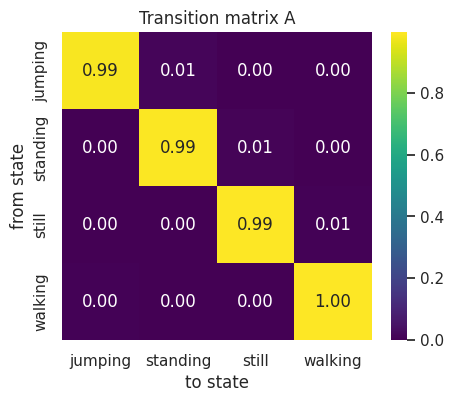

([<matplotlib.axis.YTick at 0x7b15e213fda0>,
 [Text(0, 0, 'jumping'),
  Text(0, 1, 'standing'),
  Text(0, 2, 'still'),
  Text(0, 3, 'walking')])

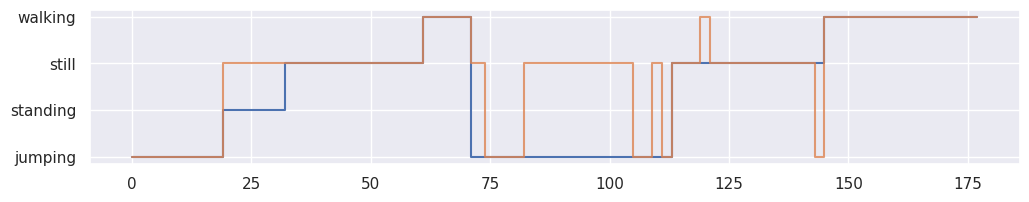

In [27]:
#  visualizations
sns.set()

# transition matrix heatmap
plt.figure(figsize=(5,4))
labels = [idx2label[i] for i in range(n_states)]
sns.heatmap(A, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cmap="viridis")
plt.xlabel("to state"); plt.ylabel("from state"); plt.title("Transition matrix A"); plt.show()

# timeline for test (concatenate test sessions)
true_cat = np.concatenate(y_test_enc)
pred_cat = np.concatenate(y_test_pred_enc)
plt.figure(figsize=(12,2))
t = np.arange(len(true_cat))
plt.step(t, true_cat, where='post', label='true')
plt.step(t, pred_cat, where='post', label='pred', alpha=0.8)
plt.yticks(list(range(n_states)), labels=[idx2label[i] for i in range(n_states)])

### HMM Evaluation & Interpretation

- Overall accuracy: 0.7472  
- Class index: 0 = jumping, 1 = standing, 2 = still, 3 = walking

---

#### Transition matrix (summary)
- Strong diagonal: the model strongly favors remaining in the same activity.
- Rare off-diagonals: transitions between different activities are uncommon.

Interpretation:
- The model captures temporal continuity well — once in a state it tends to stay there.
- Near-perfect self-transition for some states suggests long continuous segments for those activities in the dataset.

---

#### Viterbi decoded sequences (summary)
- Predicted sequences generally follow ground truth and show temporal consistency.
- Occasional short flips occur between similar activities (e.g., jumping ↔ still, standing ↔ still), indicating confusion when motion signatures overlap.

---

#### Key observations
- Standing is not being detected reliably and is confused with still — the model fails to separate these low-movement states.
- Jumping is often mistaken for still, implying feature overlap for transient, low-amplitude movements.
- Walking is well recognized in the evaluated set, indicating distinct motion patterns for that class.

---

